# Import the data

In [1]:
import os
import glob
import numpy as np

In [2]:
def load_data(root = '../input/quickdraw-np/', vfold_ratio= 0.2, max_items_per_class= 5000, print_progress= False):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    count = 0
    #load each data file 
    for idx, file in enumerate(all_files):
        if idx > 100:
            continue
        
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)
        
        if print_progress:
            count += 1
            print(f"Loaded {count} of. Last class name: {class_name} with index {idx} ")

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    
    return x_train.reshape((len(x_train), 28,28,1)), y_train, x_test.reshape((len(x_test), 28,28,1)), y_test, class_names

In [3]:
x_train, y_train, x_test, y_test, class_names = load_data(print_progress=True)
num_classes = len(class_names)

Loaded 1 of. Last class name: bandage with index 0 
Loaded 2 of. Last class name: church with index 1 
Loaded 3 of. Last class name: see saw with index 2 
Loaded 4 of. Last class name: hot air balloon with index 3 
Loaded 5 of. Last class name: wine bottle with index 4 
Loaded 6 of. Last class name: cup with index 5 
Loaded 7 of. Last class name: floor lamp with index 6 
Loaded 8 of. Last class name: garden with index 7 
Loaded 9 of. Last class name: penguin with index 8 
Loaded 10 of. Last class name: helmet with index 9 
Loaded 11 of. Last class name: speedboat with index 10 
Loaded 12 of. Last class name: donut with index 11 
Loaded 13 of. Last class name: paper clip with index 12 
Loaded 14 of. Last class name: whale with index 13 
Loaded 15 of. Last class name: chair with index 14 
Loaded 16 of. Last class name: train with index 15 
Loaded 17 of. Last class name: necklace with index 16 
Loaded 18 of. Last class name: snorkel with index 17 
Loaded 19 of. Last class name: foot with 

# Normalize the data

In [4]:
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train - mean) / (std+1e-7)
x_test = (x_test - mean) / (std+1e-7)

# Convert expected to categorical

In [5]:
from tensorflow.keras.utils import to_categorical

In [6]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Veryfing data format

In [7]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  

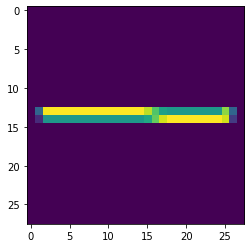

In [8]:
plt.imshow(x_train[2]) 

# Setting training validation data

In [9]:
data_count = len(x_train)
train_data_percentage = .9
validation_data_percentage = 1.0 - train_data_percentage

train_count = int(data_count * train_data_percentage);
validation_count = data_count - train_count

In [10]:
(x_train, x_valid) = x_train[validation_count:], x_train[:validation_count]
(y_train, y_valid) = y_train[validation_count:], y_train[:validation_count]

# Creating the model

In [11]:
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

In [12]:
# num convoluciones por capa convolucional
base_filtros = 32
w_regulatizer = 1e-4
model_file_name = 'best_model.hdf5'

In [13]:
model = Sequential()
## conv 1
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

## conv 2
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

## conv 3
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

## conv 4
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

## conv 5
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())


## conv 6
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

## Clasificacion - Flatten

model.add(Flatten())
model.add(Dense(num_classes,activation='softmax'))

#if os.path.exists(model_file_name):
#    model.load_weights(model_file_name)

model.summary()

2022-08-19 20:48:13.411312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 20:48:13.507546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 20:48:13.508351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 20:48:13.510259: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(),
             metrics=['accuracy'])

# Data augmentation

In [15]:
datagen = ImageDataGenerator(rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

# Checkpoint

In [16]:
chekcpoint = ModelCheckpoint(model_file_name,verbose=1,save_best_only=True, monitor = 'val_accuracy')

# Training

In [ ]:
hist = model.fit(datagen.flow(x_train, y_train, batch_size=128),
          callbacks=[chekcpoint],
          #steps_per_epoch=x_train.shape[0], 
          epochs=120,
          verbose=2,
          validation_data=(x_valid, y_valid)
         )

2022-08-19 20:48:17.266536: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/120


2022-08-19 20:48:19.278808: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2841/2841 - 99s - loss: 2.4957 - accuracy: 0.4065 - val_loss: 1.5019 - val_accuracy: 0.6357

Epoch 00001: val_accuracy improved from -inf to 0.63572, saving model to best_model.hdf5
Epoch 2/120
2841/2841 - 88s - loss: 1.7029 - accuracy: 0.5878 - val_loss: 1.3020 - val_accuracy: 0.6995

Epoch 00002: val_accuracy improved from 0.63572 to 0.69946, saving model to best_model.hdf5
Epoch 3/120
2841/2841 - 88s - loss: 1.5713 - accuracy: 0.6285 - val_loss: 1.2252 - val_accuracy: 0.7217

Epoch 00003: val_accuracy improved from 0.69946 to 0.72168, saving model to best_model.hdf5
Epoch 4/120
2841/2841 - 88s - loss: 1.5114 - accuracy: 0.6483 - val_loss: 1.1908 - val_accuracy: 0.7376

Epoch 00004: val_accuracy improved from 0.72168 to 0.73762, saving model to best_model.hdf5
Epoch 5/120
2841/2841 - 90s - loss: 1.4707 - accuracy: 0.6625 - val_loss: 1.2093 - val_accuracy: 0.7337

Epoch 00005: val_accuracy did not improve from 0.73762
Epoch 6/120
2841/2841 - 87s - loss: 1.4507 - accuracy: 0.6698 - val

# Model evaluation 

In [ ]:
plt.plot(hist.history['accuracy'],label='Train')
plt.plot(hist.history['val_accuracy'],label='Val')
plt.legend()
plt.show()

In [ ]:
model.evaluate(x_test,y_test)